In [3]:
%matplotlib inline

import os
import requests
import zipfile
import re
import copy
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from spacy import displacy

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn.functional import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard.writer import SummaryWriter

from tqdm import tqdm
from pprint import pprint

import gensim
import gensim.downloader as gloader
from gensim.models.keyedvectors import KeyedVectors

import Levenshtein
import polyleven

from functools import reduce
from typing import List, Set, Tuple, Dict, Any, Callable, Optional
from collections.abc import Iterable

plt.style.use('ggplot')

random_seed = 42

np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
DATASET_FOLDER = "../input/feedback-prize-2021"

def load_data_csv() -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(DATASET_FOLDER, 'train.csv'), 
        dtype={'discourse_id': 'int64', 'discourse_start': int, 'discourse_end': int})

def load_file(file_id: str, folder: str = 'train') -> str:
    path = os.path.join(DATASET_FOLDER, folder, file_id + '.txt')
    with open(path, 'r') as f:
        text = f.read()
    return text

def load_texts(folder: str = 'train') -> pd.Series:
    data_path = os.path.join(DATASET_FOLDER, folder)

    def read(filename):
        with open(os.path.join(data_path, filename), 'r') as f:
            text = f.read()
        return text

    return pd.Series({fname.replace('.txt', ''): read(fname) for fname in tqdm(os.listdir(data_path))})     

def load_dataset() -> Tuple[pd.Series, pd.DataFrame]:
    return load_texts(), load_data_csv()

In [33]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)


def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()

PREPROC_PIPELINE = [
    lower,
    replace_special_characters,
    # remove_stopwords,
    filter_out_uncommon_symbols,
    strip_text
]

# Anchor method

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = PREPROC_PIPELINE if filter_methods is None else filter_methods
    ret = reduce(lambda txt, f: f(txt), filter_methods, text)
    if len(ret) == 0:
        print(text)
    return ret


In [34]:
def load_glove_embedding(embedding_size: int=50) -> KeyedVectors:
    download_path = f'glove-wiki-gigaword-{embedding_size}'

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

def get_unique_words(texts: pd.Series) -> Set[str]:
    words = []

    for text in texts:
        text = text_prepare(text)
        words.extend(text.split())
            
    return set(words)

In [35]:
# Credits for this part of visualisation _> https://www.kaggle.com/thedrcat

DISCOURSE_TYPES_COLORS = {
    'Lead': '#8000ff',
    'Position': '#2b7ff6',
    'Evidence': '#2adddd',
    'Claim': '#80ffb4',
    'Concluding Statement': 'd4dd80',
    'Counterclaim': '#ff8042',
    'Rebuttal': '#ff0000'
}

def highlight_segments(id_example, texts, data):         
    ents = []
    for _, row in data[data['id'] == id_example].iterrows():
        ents.append({
            'start': int(row['discourse_start']), 
            'end': int(row['discourse_end']), 
            'label': row['discourse_type']
            })
    doc2 = {'text': texts[id_example], 'ents': ents, 'title': id_example}
    options = {'ents': data.discourse_type.unique().tolist(), 'colors': DISCOURSE_TYPES_COLORS}
    displacy.render(doc2, style='ent', options=options, manual=True, jupyter=True)

In [36]:
train_texts, train_data = load_dataset()

100%|██████████| 15594/15594 [00:01<00:00, 10465.40it/s]


In [37]:
test_texts = load_texts('test')

100%|██████████| 5/5 [00:00<?, ?it/s]


In [38]:
train_data.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [39]:
EMBEDDING_DIM = 50
glove_embedding = load_glove_embedding(EMBEDDING_DIM)

In [41]:
class TypoCorrecter:
    def __init__(self, vocab_keys: List[str]) -> None:
        self.vocab_keys = vocab_keys
        self.vocab_array = np.array(list(self.vocab_keys))
        self.str_number_keys = [n for n in self.vocab_keys if self.isNumber(n)]
        self.number_keys = np.array(self.str_number_keys, dtype=np.float32)

        self.LETTERS = re.compile('[a-z]')

    def __call__(self, word: str, threshold=1) -> str:
        if word in self.vocab_keys:
            return word

        if self.LETTERS.match(word): # avoid to use Levenshtein on numbers
            dist = lambda elem: polyleven.levenshtein(word, elem, threshold)
            distances = np.vectorize(dist)(self.vocab_array)
            idx_min = np.argmin(distances)
            if distances[idx_min] <= threshold:
                return self.vocab_array[idx_min]

        try:
            # maybe it is a number, convert to the nearest one
            word = word.replace(',', '')
            number = float(word)

            idx = np.argmin(np.abs(self.number_keys - number))
            return self.str_number_keys[idx]

        except ValueError:
            # nothing can be done, return the old word
            return word

    @staticmethod
    def isNumber(n) -> bool:
        if n == 'nan':
            return False
        try:
            float(n)
            return True
        except ValueError:
            return False

def handling_OOV(words: Set[str], OOV: Set[str], embedder: KeyedVectors):
    '''
    Try to check if OOV are due to:
        1)Decimal numbers; 
        2)words separated by special character (-, \\/)compuound words ;
        3)Words compuound by two words present in the vocabulary; 
        4)Typos;
    '''

    '''
    Words separated by special characters are encoded using the embedding of the two words.
    For other words we just check the spelling and try to approximate number.
    '''
    vocab_keys: List[str] = embedder.index_to_key
    correct_typo = TypoCorrecter(vocab_keys)

    print("Correcting numbers, typos and words separated by special characters.")

    to_add = {}
    for w in tqdm(OOV):
        try:
            if '-' in w:
                subWords = w.split('-')
                embedded_words = [embedder[correct_typo(subW)] for subW in subWords if subW]
                to_add[w] = np.mean(embedded_words, axis=0)

            elif '_' in w:
                subWords = w.split('-')
                embedded_words = [embedder[correct_typo(subW)] for subW in subWords if subW]
                to_add[w] = np.mean(embedded_words, axis=0)
            
            elif '\\/' in w:
                subWords = w.split('\\/')
                embedded_words = [embedder[correct_typo(subW)] for subW in subWords]
                to_add[w] = np.mean(embedded_words, axis=0)

            else:
                to_add[w] = embedder[correct_typo(w)]

        except KeyError:
            pass
    
    keys, values = to_add.items()
    embedder.add_vectors(list(keys), list(values))
    
    vocab_keys: List[str] = embedder.index_to_key
    OOV = words.difference(set(vocab_keys))
    print("There are", len(OOV), "OOV")
    
    # Compound words
    print('Analyzing compound words')
    to_add = {}
    for w in tqdm(OOV):
        for i in range(2, len(w)-2):
            w1 = w[:i]
            w2 = w[i:]
            if w1 in vocab_keys and w2 in vocab_keys:
                embedding = (embedder[w1] + embedder[w2]) / 2
                to_add[w] = embedding
                break
    keys, values = to_add.items()
    embedder.add_vectors(list(keys), list(values))
  
    vocab_keys: List[str] = embedder.index_to_key
    OOV = words.difference(set(vocab_keys))
    print("There are", len(OOV), "OOV")

    # Typos
    print('Correcting typos with Levenshtein distance up to 2')
    correct_typo = TypoCorrecter(vocab_keys)
    to_add = {}

    for w in tqdm(OOV):
        try:
            new_w = correct_typo(w, threshold=2)
            to_add[w] = embedder[new_w]
        except KeyError:
            pass

    keys, values = to_add.items()
    embedder.add_vectors(list(keys), list(values))

    vocab_keys: List[str] = embedder.index_to_key
    OOV = words.difference(set(vocab_keys))
    print("There are", len(OOV), "OOV")
    return OOV

In [62]:
# def isNumber(n) -> bool:
#     if n == 'nan':
#         return False
#     try:
#         float(n)
#         return True
#     except ValueError:
#         return False

# vocab_keys = glove_embedding.index_to_key
# vocab_array = np.array(list(vocab_keys))
# str_number_keys = [n for n in vocab_keys if isNumber(n)]
# number_keys = np.array(str_number_keys, dtype=np.float32)

# ALL_WORDS = re.compile('[a-z]')

# def correct_typo(word: str, threshold=1) -> str:
#     if word in vocab_keys:
#         return word

#     if ALL_WORDS.match(word): #avoid to use Levenshtein on numbers
#         dist = lambda elem: polyleven.levenshtein(word, elem)
#         distances = np.vectorize(dist)(vocab_array)
#         idx_min = np.argmin(distances)
#         if distances[idx_min] <= threshold:
#             return vocab_array[idx_min]

#     #maybe it is a number, convert to the nearest one
#     try:
#         word = word.replace(',', '')
#         number = float(word)

#         idx = np.argmin(np.abs(number_keys - number))
#         return str_number_keys[idx]

#     except ValueError:
#         return word



# def handling_OOV(words, OOV: Set[str], embedder: KeyedVectors):
#     '''
#     Try to check if OOV are due to:
#         1)Decimal numbers; 
#         2)words separated by special character (-, \\/)compuound words ;
#         3)Words compuound by two words present in the vocabulary; 
#         4)Typos;
#     '''

#     '''
#     Words separated by special characters are encoded using the embedding of the two words.
#     For other words we just check the spelling and try to approximate number.
#     '''
#     print("Correcting numbers, typos and words separated by special characters.")
#     to_add = {}
#     for w in tqdm(OOV):
#         try:
#             if '-' in w:
#                 subWords = w.split('-')
#                 embedded_words = [embedder[correct_typo(subW)] for subW in subWords if subW]
#                 to_add[w] = np.mean(embedded_words, axis=0)

#             elif '_' in w:
#                 subWords = w.split('-')
#                 embedded_words = [embedder[correct_typo(subW)] for subW in subWords if subW]
#                 to_add[w] = np.mean(embedded_words, axis=0)
            
#             elif '\\/' in w:
#                 subWords = w.split('\\/')
#                 embedded_words = [embedder[correct_typo(subW)] for subW in subWords]
#                 to_add[w] = np.mean(embedded_words, axis=0)

#             else:
#                 to_add[w] = embedder[correct_typo(w)]

#         except KeyError:
#             pass
    
#     keys, values = to_add.items()
#     embedder.add_vectors(list(keys), list(values))

#     OOV = set(words).difference(set(embedder.index_to_key))
#     print("There are", len(OOV), "OOV")
    
#     # Compound words
#     print('Analyzing compound words')
#     to_add = {}
#     for w in tqdm(OOV):
#         for i in range(2, len(w)-2):
#             w1 = w[:i]
#             w2 = w[i:]
#             if w1 in vocab_keys and w2 in vocab_keys:
#                 embedding = (embedder[w1] + embedder[w2]) / 2
#                 to_add[w] = embedding
#                 break
#     keys, values = to_add.items()
#     embedder.add_vectors(list(keys), list(values))
  
#     OOV = set(words).difference(set(embedder.index_to_key))
#     print("There are", len(OOV), "OOV")

#     # Typos
#     print('Correcting typos with Levenshtein distance up to 2')
#     to_add = {}

#     for w in tqdm(OOV):
#         try:
#             new_w = correct_typo(w, threshold=2)
#             to_add[w] = embedder[new_w]
#         except KeyError:
#             pass

#     keys, values = to_add.items()
#     embedder.add_vectors(list(keys), list(values))

#     OOV = set(words).difference(set(embedder.index_to_key))
#     print("\nThere are", len(OOV), "OOV")
#     return OOV

In [42]:
train_words = get_unique_words(train_texts)
test_words = get_unique_words(test_texts)
unique_words = set.union(train_words, test_words)

print(f'Train unique words : {len(train_words)}')
print(f'Test unique words  : {len(test_words)}')
print(f'Total unique words : {len(unique_words)}')

Train unique words : 96090
Test unique words  : 739
Total unique words : 96125


In [43]:
glove_keys = set(glove_embedding.index_to_key)
train_oov= set(train_words).difference(glove_keys)
test_oov = set(test_words).difference(glove_keys)
OOV = set(unique_words).difference(glove_keys)

print('Before processing')
print(f'Train OOV : {len(train_oov)} ({100*len(train_oov)/len(train_words):.2f}%)')
print(f'Test OOV  : {len(test_oov)}  ({100*len(test_oov)/len(test_words):.2f}%)')
print(f'Total OOV : {len(OOV)} ({100*len(OOV)/len(unique_words):.2f}%)')

Before processing
Train OOV : 70394 (73.26%)
Test OOV  : 34  (4.60%)
Total OOV : 70407 (73.25%)


In [44]:
OOV = handling_OOV(unique_words, OOV, glove_embedding)

Correcting numbers, typos and words separated by special characters.


 13%|█▎        | 8981/70407 [1:04:23<7:20:26,  2.32it/s]    


KeyboardInterrupt: 

In [ ]:
glove_keys = set(glove_embedding.index_to_key)
train_oov= set(train_words).difference(glove_keys)
test_oov = set(test_words).difference(glove_keys)
OOV = set(unique_words).difference(glove_keys)

print('After processing')
print(f'Train OOV : {len(train_oov)} ({100*len(train_oov)/len(train_words):.2f}%)')
print(f'Test OOV  : {len(test_oov)}  ({100*len(test_oov)/len(test_words):.2f}%)')
print(f'Total OOV : {len(OOV)} ({100*len(OOV)/len(unique_words):.2f}%)')

After processing
Train OOV : 27965 (52.29%)
Test OOV  : 8  (1.26%)
Total OOV : 27966 (52.27%)


<AxesSubplot:>

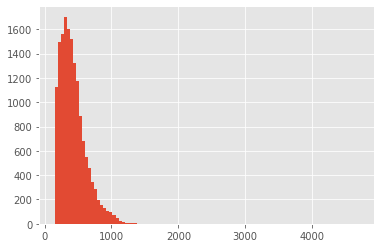

In [8]:
txt_len = train_texts.map(lambda x: len(x.split()))
txt_len.hist(bins=100)

<AxesSubplot:>

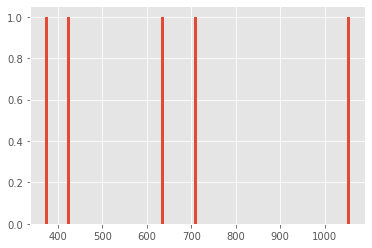

In [9]:
txt_len = test_texts.map(lambda x: len(x.split()))
txt_len.hist(bins=100)

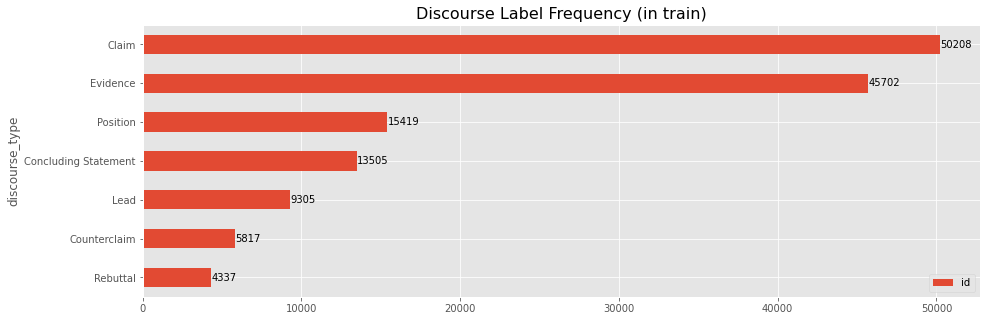

In [7]:
# Most annotation used:

ax = (
    train_data.groupby(by='discourse_type')[['id']]
    .count()
    .sort_values('id')
    .plot(kind="barh", figsize=(15, 5))
)
ax.set_title("Discourse Label Frequency (in train)", fontsize=16)
ax.bar_label(ax.containers[0], label_type="edge")
plt.show()

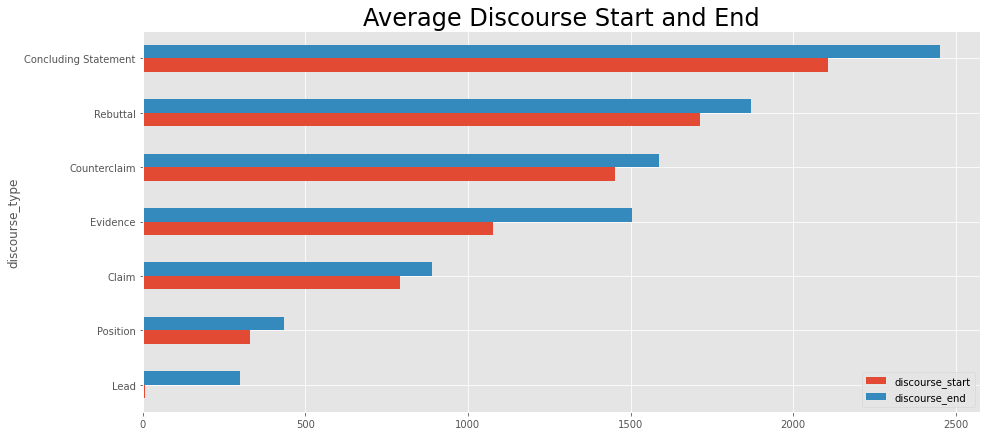

In [8]:
ax = (
    train_data.groupby("discourse_type")[["discourse_start", "discourse_end"]]
    .mean()
    .sort_values("discourse_start")
    .plot(kind="barh", figsize=(15, 7))
)
ax.set_title("Average Discourse Start and End", fontsize=24)
plt.show()

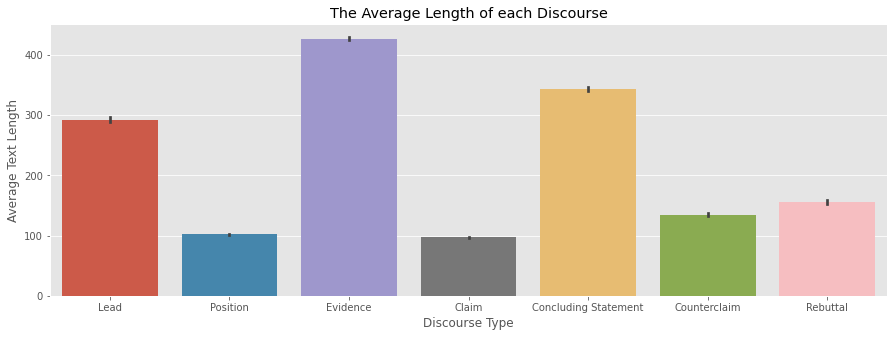

In [9]:
# The length of each label
tmp = train_data.copy()
tmp['discourse_len'] = (tmp['discourse_end'] - tmp['discourse_start']).astype('int')

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='discourse_type', y='discourse_len', data=tmp)
ax.set_title('The Average Length of each Discourse')
ax.set_xlabel('Discourse Type')
ax.set_ylabel('Average Text Length')
plt.show()

In [12]:
largest_gap = []

for group_id, group in train_data.groupby(by='id'):
    end = -1
    largest = 0
    for _, row in group.iterrows():
        init = row.discourse_start
        diff = init - end - 1
        largest = max(largest, diff)
        end = row.discourse_end
    largest_gap.append({'id': group_id, 'largest_gap': largest})
gaps = pd.DataFrame(largest_gap).sort_values(by='largest_gap').reset_index(drop=True)
gaps.head()

,id,largest_gap
0,0000D23A521A,0
1,7BE3B580C5DB,0
2,7BC12E549AF3,0
3,7BB808935B65,0
4,7BA662FCD635,0


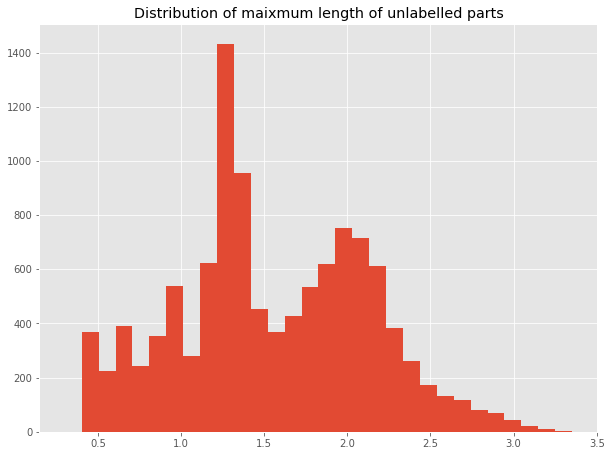

,largest_gap
count,11194.000000
mean,83.413793
std,145.294047
min,1.000000
25%,15.000000
50%,28.000000
75%,101.000000
max,2246.000000


In [11]:
non_zero_gaps = gaps[gaps['largest_gap'] != 0]
ax = (non_zero_gaps['largest_gap'].apply(lambda x: np.log10(x + 1)).hist(bins=30, figsize=(10, 7.5)))
ax.set_title('Distribution of maixmum length of unlabelled parts')
plt.show()
non_zero_gaps.describe()

In [23]:
max_gap_id = gaps[gaps.largest_gap == 2].reset_index()['id'][15]
highlight_segments(max_gap_id, train_texts, train_data)

In [24]:
train_data[train_data['id'] == 'F4A4E65ADD95']

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
134826,F4A4E65ADD95,1618271320788,0,287,Other people can be a helpful source of inform...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
134827,F4A4E65ADD95,1618271316656,288,396,You would be a lot more confident in the car t...,Position,Position 1,54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 6...
134828,F4A4E65ADD95,1618271327288,397,529,Confiding in multiple different people when lo...,Claim,Claim 1,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
134829,F4A4E65ADD95,1618271332879,530,576,"listen to multiple different ideas/opinions,",Claim,Claim 2,97 98 99 100 101
134830,F4A4E65ADD95,1618271337647,579,610,get a more detailed response.,Claim,Claim 3,103 104 105 106 107
134831,F4A4E65ADD95,1618271342048,611,696,The experiences of other people are a valuable...,Claim,Claim 4,108 109 110 111 112 113 114 115 116 117 118 11...
134832,F4A4E65ADD95,1618271349728,696,1156,Asking people about their experiences will giv...,Evidence,Evidence 1,123 124 125 126 127 128 129 130 131 132 133 13...
134833,F4A4E65ADD95,1618271377462,1157,1801,\nIf you were planning a vacation and you coul...,Evidence,Evidence 2,200 201 202 203 204 205 206 207 208 209 210 21...
134834,F4A4E65ADD95,1618271363994,1802,1899,The ideas and opinions of other can be a very ...,Claim,Claim 5,324 325 326 327 328 329 330 331 332 333 334 33...
134835,F4A4E65ADD95,1618271398384,1900,1987,You can get a much more detailed response if y...,Claim,Claim 6,343 344 345 346 347 348 349 350 351 352 353 35...
